<a href="https://colab.research.google.com/github/Munfred/worm-tutorials/blob/main/ChromosomeMapTool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A Google Colab Tool written by Raymond Lee (raymond+colab@caltech.edu)

# USAGE: Enter a list of *C. elegans* gene names to plot a chromosome **physical** map.

In [1]:
#@title
# From WormMine (should be replaced with a more direct DB query.)
%pip install intermine
from __future__ import print_function
from intermine.webservice import Service
service = Service("http://intermine.wormbase.org/tools/wormmine/service")

     |████████████████████████████████| 81kB 2.2MB/s 


In [2]:
#@title
# ref: https://www.w3resource.com/python-exercises/class-exercises/python-class-exercise-2.php
def roman_to_int(s):
  rom_val = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
  int_val = 0
  for i in range(len(s)):
    if i > 0 and rom_val[s[i]] > rom_val[s[i - 1]]:
      int_val += rom_val[s[i]] - 2 * rom_val[s[i - 1]]
    else:
      int_val += rom_val[s[i]]
  return int_val

# print(roman_to_int('MMMCMLXXXVI'))

In [3]:
#@title
!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSans-hinted.zip"
!unzip "NotoSans-hinted.zip"
!mv "NotoSans-BoldItalic.ttf" "/usr/share/fonts/truetype"
!mv "NotoSans-Bold.ttf" "/usr/share/fonts/truetype"
!mv "NotoSans-Italic.ttf" "/usr/share/fonts/truetype"
!mv "NotoSans-ExtraBoldItalic.ttf" "/usr/share/fonts/truetype"

--2020-10-14 18:50:16--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSans-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 64.233.170.128, 2607:f8b0:400c:c0d::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16796031 (16M) [application/zip]
Saving to: ‘NotoSans-hinted.zip’

NotoSans-hinted.zip 100%[===================>]  16.02M  23.3MB/s    in 0.7s    

2020-10-14 18:50:17 (23.3 MB/s) - ‘NotoSans-hinted.zip’ saved [16796031/16796031]

Archive:  NotoSans-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSans-Black.ttf      
  inflating: NotoSans-BlackItalic.ttf  
  inflating: NotoSans-Bold.ttf       
  inflating: NotoSans-BoldItalic.ttf  
  inflating: NotoSans-Condensed.ttf  
  inflating: NotoSans-CondensedBlack.ttf  
  inflating: NotoSans-CondensedBlackItalic.ttf  
  inflati

In [4]:
#@title
# ref: https://stackoverflow.com/questions/245447/how-do-i-draw-text-at-an-angle-using-pythons-pil
def rotatetxt(text='test', degree=90):
  from PIL import Image, ImageFont, ImageDraw, ImageOps

  font = ImageFont.truetype("/usr/share/fonts/truetype/NotoSans-ExtraBoldItalic.ttf", size=12)
  width, height = font.getsize(text)

  image = Image.new('L', (height+50, width))
  draw = ImageDraw.Draw(image)
  draw.text((0, 0), text, font=font, fill=255)
  writeout = image.rotate(degree, expand=1)
  return writeout


 


# Get Genes

In [5]:
#@title Enter a list of <i>C. elegans</i> gene names (separated by comma)
GeneNames = "eat-4, egl-19, eat-8, glr-1, C26C6.1, sea-2, WBGene00006669, lin-15A, ctb-1, madf-5, F19B2.10, gpa-3" #@param {type:"string"}
import regex as re
gene_strings = re.split('; |, |\*|\n', GeneNames)
# print(gene_strings)


In [6]:
#@title
genes_found = {}
genes_notfound = []
# From WormMine (should be replaced with a more direct DB query.)

for gene_name in gene_strings:
  gene_name = gene_name.strip()
  genequery = service.new_query("Gene") # service defined in previous block
  genequery.add_view("chromosome.primaryIdentifier", "locations.start")
  genequery.add_constraint("Gene", "LOOKUP", gene_name, "C. elegans", code = "A")

  if gene_name not in genes_found:  # gather list of non redundant genes
    if not genequery.rows():
      genes_notfound.append(gene_name)
    else:
      for generow in genequery.rows():
        gene_id, gene_pub_name, gene_chr, gene_loc = generow["primaryIdentifier"], generow["symbol"], generow["chromosome.primaryIdentifier"], generow["locations.start"]
        genes_found.update({gene_id : [gene_pub_name, gene_chr, gene_loc]})
print('Genes Mapped', genes_found)
print('Genes Not Mapped ', genes_notfound)

Genes Mapped {'WBGene00001135': ['eat-4', 'III', 9136887], 'WBGene00001187': ['egl-19', 'IV', 7405582], 'WBGene00001612': ['glr-1', 'III', 8584163], 'WBGene00007042': ['pbrm-1', 'I', 7495429], 'WBGene00004751': ['sea-2', 'II', 3950377], 'WBGene00006669': ['twk-14', 'V', 12387039], 'WBGene00023498': ['lin-15A', 'X', 15731963], 'WBGene00000829': ['ctb-1', 'MtDNA', 4504], 'WBGene00007242': ['madf-5', 'II', 14573608], 'WBGene00043055': ['F19B2.10', 'V', 20176101], 'WBGene00001665': ['gpa-3', 'V', 9356579]}
Genes Not Mapped  ['eat-8']


# Fetch Chromosomes

In [7]:
#@title
# Get Chromosomes and Lengths
Chrquery = service.new_query("Chromosome")
Chrquery.add_view("primaryIdentifier", "length")
chromosomes = {}
for chrrow in Chrquery.rows():
  (chrom_label, length) = (chrrow["primaryIdentifier"], chrrow["length"])
  if 'X' in chrom_label:
    chr_num = (5+1)
  elif 'MtDNA' in chrom_label:
    chr_num = (6+1) 
  else:
    chr_num = roman_to_int(chrom_label)
  chromosomes.update({chr_num : [chrom_label, length]})

# print(sorted(chromosomes.items()))

# Plot

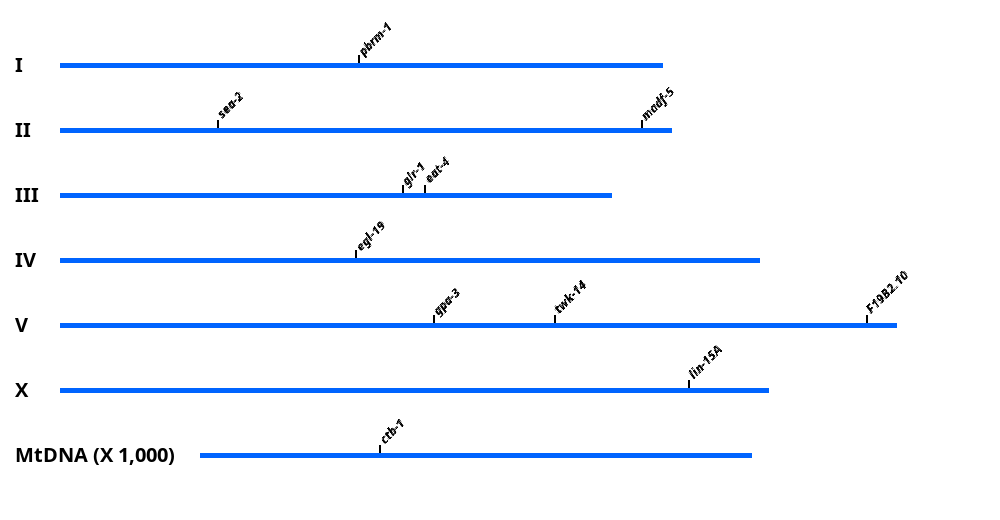

In [8]:
#@title
from PIL import Image, ImageDraw, ImageFont, ImageOps

spacer = 65   # increase this to expand graph height
headspace = 60
mitohead = 200
txthead = 15
nameshift = 65
autoscale = 25000   # reduce this to expand graph width
mitoscale = (autoscale / 1000)

im = Image.new('RGB', (int(25000000 / autoscale), (spacer * 8)), (255, 255, 255)) # canvas dimension and color
graph = ImageDraw.Draw(im)



for chromosome in chromosomes:
  (chrnum, chromlabel, chromlength) = \
  (chromosome, chromosomes[chromosome][0], chromosomes[chromosome][1])
  font = ImageFont.truetype("/usr/share/fonts/truetype/NotoSans-Bold.ttf", size=20)
  if 'MtDNA' in chromlabel:
    graph.line((mitohead, (spacer * chrnum), (chromlength/mitoscale + mitohead), (spacer * chrnum)), fill=(0, 100, 255), width=5)
    graph.text((txthead, (spacer * chrnum - 15)),(chromlabel + ' (X 1,000)'),(0,0,0),font=font)
  else:
    graph.line((headspace, (spacer * chrnum), (chromlength/autoscale + headspace), (spacer * chrnum)), fill=(0, 100, 255), width=5)
    graph.text((txthead, (spacer * chrnum - 15)),(chromlabel),(0,0,0),font=font)

for gene in genes_found:
  (geneid, pubname, chromo, location) = \
  (gene, genes_found[gene][0], genes_found[gene][1], genes_found[gene][2])
  font = ImageFont.truetype("/usr/share/fonts/truetype/NotoSans-BoldItalic.ttf")
  if 'MtDNA' in chromo:
    chrnum = 7
    graph.line(((location/mitoscale + mitohead), (spacer * chrnum -2.5 ), (location/mitoscale + mitohead), (spacer * chrnum - 10)), fill=(0, 0, 0), width=2)
    im.paste( ImageOps.colorize(rotatetxt(pubname, 45), (0,0,0), (0,0,0)), (int(location/mitoscale + mitohead - 5), (spacer * chrnum - nameshift)),  rotatetxt(pubname, 45))
#    graph.text(((location/mitoscale + mitohead), (spacer * chrnum - 25)), pubname, (0,0,0), font=font)
  elif 'X' in chromo:
    chrnum = 6
    graph.line(((location/autoscale + headspace), (spacer * chrnum -2.5 ), (location/autoscale + headspace), (spacer * chrnum - 10)), fill=(0, 0, 0), width=2)
    im.paste( ImageOps.colorize(rotatetxt(pubname, 45), (0,0,0), (0,0,0)), (int(location/autoscale + headspace - 5), (spacer * chrnum - nameshift)),  rotatetxt(pubname, 45))
#    graph.text(((location/autoscale + headspace), (spacer * chrnum - 25)), pubname, (0,0,0), font=font)
  else:
    chrnum = roman_to_int(chromo)
    graph.line(((location/autoscale + headspace), (spacer * chrnum -2.5 ), (location/autoscale + headspace), (spacer * chrnum - 10)), fill=(0, 0, 0), width=2)
    im.paste( ImageOps.colorize(rotatetxt(pubname, 45), (0,0,0), (0,0,0)), (int(location/autoscale + headspace - 5), (spacer * chrnum - nameshift)),  rotatetxt(pubname, 45))
#    graph.text(((location/autoscale + headspace), (spacer * chrnum - 25)), pubname, (0,0,0), font=font)

im


# Save Plot

In [9]:
#@title
im.save('ChrMap.png','')

from google.colab import files
files.download('ChrMap.png')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>